# Part 1. Create base grid with H3

### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks
from pathlib import Path

# Spatial
import geopandas as gpd ##requires geopandas >0.10
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.geometry import shape, mapping
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
from osgeo import gdal, osr, ogr
import fiona
from rasterstats import zonal_stats
import rasterio
import rasterio.fill
from geojson import Feature, Point, FeatureCollection
import h3 as h3

# Mapping / Plotting
from functools import reduce
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [3]:
from typing import cast
import h3pandas  # NoQA  type: ignore
from geopandas.tools import sjoin

In [4]:
from utils import processing_raster, finalizing_rasters

### Define area of interest

In [5]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

In [6]:
print(area)

COUNTRY


### Define directories and dataset names

In [7]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"
Path(out_path).mkdir(parents=True, exist_ok=True)
## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "gadm41_ZMB.gpkg"    ## Can be downloaded on https://gadm.org/  
region_col_name = "NAME_1"   ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"
layer_region_name = "ADM_ADM_1"
layer_admin_name = "ADM_ADM_0"

In [8]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Functions for creating heaxgons

In [9]:
def create_hex(aoi: gpd.GeoDataFrame, resolution: int) -> gpd.GeoDataFrame:
    geom = aoi.h3.polyfill_resample(resolution).get(["geometry"])
    geom = geom.assign(h3_index=geom.index)
    geom = geom.reset_index(drop=True)
    return geom

In [10]:
def add_neighbors(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    orig_crs = gdf.crs
    gdf = cast(gpd.GeoDataFrame, gdf.to_crs(epsg=3857))
    nei = []
    for idx, row in gdf.iterrows():
        out = (
            gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
            .sjoin_nearest(gdf, how="left", max_distance=0.1)
            .index_right
        )
        out = out.loc[out != idx]
        out = np.pad(out, (0, 6 - len(out)))
        nei.append(out)

    nei = pd.DataFrame(nei, columns=[f"n{i}" for i in range(6)], index=gdf.index)  # type: ignore
    gdf = pd.concat((gdf, nei), axis=1).to_crs(orig_crs)
    return gdf

In [11]:
def feat(aoi: gpd.GeoDataFrame, hex_res: int) -> gpd.GeoDataFrame:
    geom = create_hex(aoi, hex_res)
    geom = add_neighbors(geom)
    geom["index"] = geom.index
    geom = cast(gpd.GeoDataFrame, geom.dropna(axis=0, subset=["geometry"]))
    return geom

### Import layers to be used

In [12]:
## admininstrative boundary
if area == "COUNTRY":
    admin_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_admin_name)
    region_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_region_name)
else:    
    region_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_region_name)
    region_gdf = region_gdf[region_gdf[region_col_name]==area]
    admin_gdf = region_gdf

In [13]:
print(admin_gdf.crs)

EPSG:4326


In [14]:
# aoi = gpd.read_file(admin_path + "/" + admin_name, layer=layer_admin_name)

### H3 - Hegagon - grid

In [15]:
size = 6 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = feat(admin_gdf, size)
hexagons.to_file(out_path + "\\" +"hex.geojson")

In [16]:
# # Plot basemap
# fig, ax = plt.subplots(figsize=(25, 15))
# hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
# admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
# ax.set_aspect('equal', 'box')

# # Save plot as figure 
# #plt.savefig('admin level basemap.png', bbox_inches='tight')

In [17]:
region_gdf.columns

Index(['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry'],
      dtype='object')

In [18]:
# Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, region_gdf[[region_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[region_col_name].notnull()]

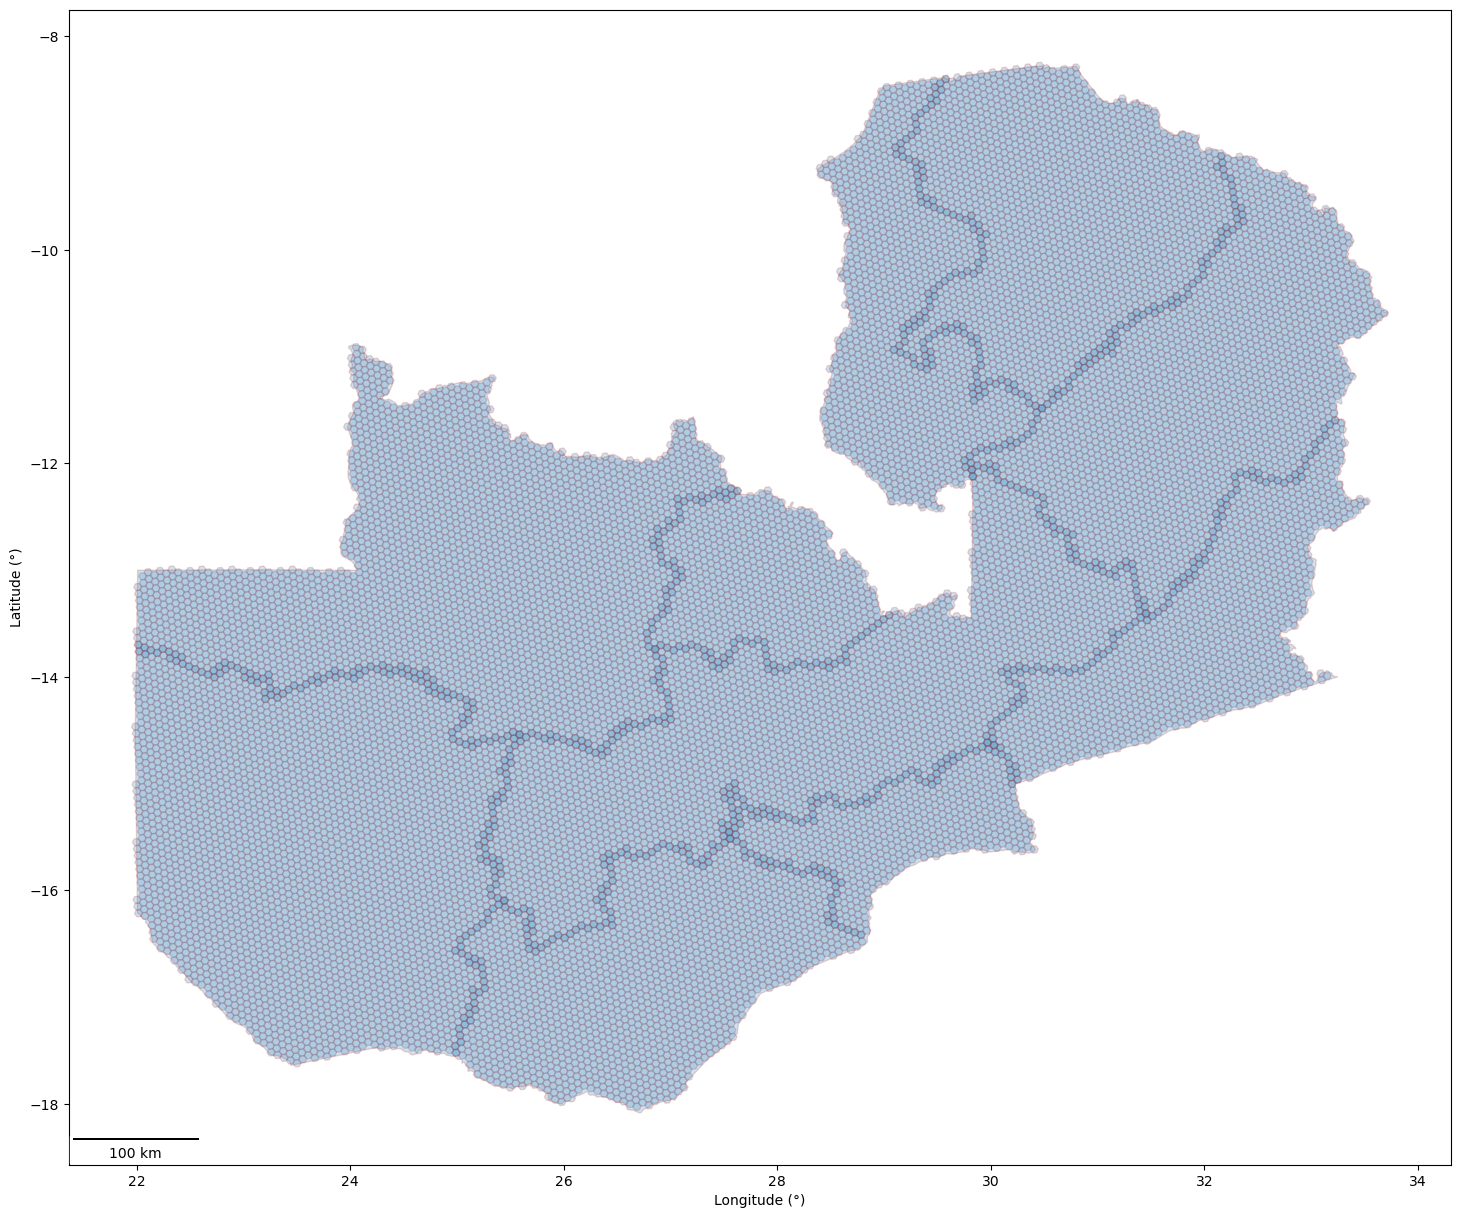

In [49]:
# Plot basemap
fig, ax = plt.subplots(figsize=(25, 15))
# fig, ax = plt.subplots(figsize=(4, 3))

hex_reproj = hexagons.to_crs(32619)  # Convert the dataset to a coordinate
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
assert admin_gdf.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'/admin_level_basemap.png', bbox_inches='tight')

#### Select base map grid

In [20]:
hexagons['id'] = range(1, len(hexagons)+1)

In [21]:
hexagons.head(3)

,geometry,h3_index,n0,n1,n2,n3,n4,n5,index,index_right,NAME_1,id
0,"POLYGON ((27.45009 -15.0168, 27.46462 -14.9828...",86962e39fffffff,9802,16042,13714,12967,8198,16196,0,0,Central,1
1,"POLYGON ((27.68644 -16.72042, 27.70105 -16.686...",8697526b7ffffff,13065,4187,2426,15247,4317,3546,1,8,Southern,2
2,"POLYGON ((26.92427 -16.23865, 26.93895 -16.204...",86962c077ffffff,11930,14011,15009,17101,5549,16636,2,8,Southern,3


In [22]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex.shp', index=False) # file used in the other scripts
admin_gdf.to_file(out_path + "\\" + f'area_gdf.gpkg', index=False)
admin_gdf.to_file(out_path + "\\" + f'area_gdf.geojson', driver='GeoJSON', index=False) 